In [ ]:
from typing import List, Tuple
import numpy as np
import glob
import os
import csv
import irig_h_gpio as irig
import threading
import matplotlib as plt

irig_files = glob.glob("data/irig_data_*.npz")
recent_file = max(irig_files, key=os.path.getmtime)
input_files = []
for irig_file in irig_files:
    if abs(os.path.getmtime(recent_file) - os.path.getmtime(irig_file)) < 10:
        input_files.append(irig_file)
# pps_filename = max(glob.glob("data/pps_data_*.npz"), key=os.path.getmtime)
print(input_files)

def to_pulse_lengths(rising_edges: np.ndarray, falling_edges: np.ndarray) -> List[Tuple[int, int]]:
    return np.column_stack((falling_edges - rising_edges, rising_edges)).tolist()

def find_sample_rate(irig_filename:str):
    irig_starts = np.load(irig_filename)['starts']

    diff = np.diff(irig_starts)
    
    return round(np.median(diff), 0), diff 

def error_analysis(irig_filename:str, pps_filename:str):
    sample_rate = find_sample_rate(irig_filename)
    print(f'Sample rate: {sample_rate}')

    jumps = 0

    irig_starts = np.load(irig_filename)['starts']
    pps_starts = np.load(pps_filename)['ends']

    min_len = min(len(irig_starts), len(pps_starts))
    irig_starts = irig_starts[:min_len].tolist()
    pps_starts = pps_starts[:min_len].tolist()

    result = []

    for irig_start, pps_start in zip(irig_starts, pps_starts):
        error = irig_start - pps_start
        while error < -sample_rate * (0.95 + jumps):
            jumps +=1
            result.append('JUMP')
        result.append(error + (sample_rate * jumps))

    cumulative = 0
    no_outliers = [r for r in result if type(r) != str and r < 15]
    for d in no_outliers:
        cumulative += d
    cumulative /= len(no_outliers)
    print(f'Average index delay without outliers: {cumulative}\nSeconds: {cumulative/sample_rate}')
    cumulative = 0
    with_outliers = [r for r in result if type(r) != str]
    for d in with_outliers:
        cumulative += d
    cumulative /= len(with_outliers)
    print(f'Average index delay with outliers: {cumulative}\nSeconds: {cumulative/sample_rate}')

    output_filename = f'error_indexes_{irig_filename[15:-4]}.csv'

    with open(output_filename, 'w', newline='') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow(result)

def decode_analysis(irig_filename:str):

    output_filename = f'decoded_timecodes_{irig_filename[15:-4]}.csv'

    print(irig_filename)

    irig_file = np.load(irig_filename)
    for item in irig_file['ends']:
        print(item)
        
    with open(output_filename, 'w', newline='') as file:
        pulse_lengths = to_pulse_lengths(irig_file['starts'], irig_file['ends'])
        irig_bits = irig.to_irig_bits(pulse_lengths)
        decoded = irig.decode_irig_bits(irig_bits)

        csv_writer = csv.writer(file)
        csv_writer.writerows(decoded)

# error_thread = threading.Thread(target=error_analysis)
# decode_thread = threading.Thread(target=decode_analysis)
# error_thread.start()
# decode_thread.start()

for filename in input_files:
    # print(find_sample_rate(filename))
    decode_analysis(filename)

['data/irig_data_20250807_121837_1.npz', 'data/irig_data_20250807_121842_0.npz']
(np.float64(32.0), array([32, 32, 31, ..., 27, 28, 32], shape=(9603,)))
(np.float64(32.0), array([31, 32, 32, ..., 32, 32, 32], shape=(9607,)))


In [12]:
import matplotlib.pyplot as plt

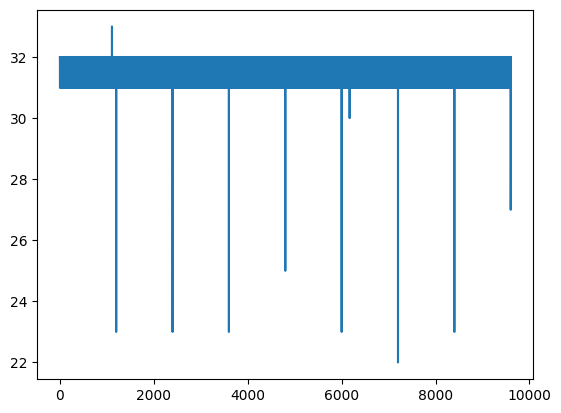

In [ ]:
plt.plot(find_sample_rate(recent_file)[1])

irig_starts = np.load(recent_file)['starts']


In [ ]:
irig_starts = np.load(recent_file)['starts']